# Algorithmic Fairness in Machine Learning

## Introduction

Risk assessment is an important component of the criminal justice system. In the United States, judges set bail and decide pre-trial detention based on their assessment of the potential risk that a released defendant will fail to appear at trial or cause harm to the public. While actuarial risk assessment is not new in this domain, there is increasing support for the use of learned risk scores to guide human judges in their decisions. Proponents argue that machine learning could lead to greater efficiency, accountability, and less biased decisions compared with human judgment ([Henry](https://theappeal.org/risk-assessment-explained/)). Critical voices raise the concern that biases can creep into these algorithms at any point in the process, and that algorithms are often applied to the wrong situations ([Henry](https://theappeal.org/risk-assessment-explained/)). Further, they exacerbate the racism embedded deep within the criminal justice system by perpetuating inequalities found in historical data ([Henry](https://theappeal.org/risk-assessment-explained/)).

In this homework, you will explore some of the many definitions and metrics of fairness that can be applied to the risk assessment tool COMPAS to understand and provide evidence for or against the presence of bias within the algorithm. You will examine the arguments and analyses made by the company that created COMPAS and their critics to gain a deeper understanding of the technical and societal interpretations and implications of fairness. 

## Table of Contents:
* [Part 0. COMPAS](#part-zero)
* [Part 1. The Coproduction of Justice and Data](#part-one)
* [Part 2. ProPublica's Perspective](#part-two)
* [Part 3. Northpointe's Perspective](#part-three)
* [Part 4. Another Definition of Fairness](#part-four)

## Setup

Let's begin by importing the packages we need that will give us the appropriate tools and methods needed.

In [3]:
import numpy as np # Loads numerical methodss
import pandas as pd # This allows us to transform our data into tables (AKA DataFrames) 

from sklearn.metrics import roc_curve, roc_auc_score # Loads visualization tools for a ROC Curve
import matplotlib.pyplot as plt # Loads more visualization tools
import seaborn as sns # Loads more visualization tools

# These install a fairness package with the DisparateImpactRemover tool used in Part 4
!pip install aif360
!pip install BlackBoxAuditing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset

  Using cached aif360-0.3.0-py3-none-any.whl (165 kB)
Processing /home/jovyan/.cache/pip/wheels/e3/77/36/a32ec1b04c2ebe2c45e88d42f33f22f987e76aad3f297b681e/BlackBoxAuditing-0.1.54-py2.py3-none-any.whl


pip install 'aif360[LFR]'


# Part 0. COMPAS: Why it was created and how it exists in the court system <a id="part-zero"></a>

COMPAS is a commercial tool produced by the for-profit company Northpointe known as a recidivism risk assessment system. Tools like COMPAS are used to **predict the risk of future crimes for an individual who has entered the US criminal justice system by outputting a risk score from 1-10**. While COMPAS was initially intended to aid decisions made by probation officers on treatment and supervision of those who are incarcerated, Northpointe has since emphasized the scalability of the tool to “fit the needs of many different decision points” including pre-screening assessments, pretrial release decisions (whether or not to hold an arrested individual in jail until their trial), and post-trial next steps for the defendant ([Northpointe](http://www.northpointeinc.com/files/downloads/FAQ_Document.pdf)). These algorithms are believed by many to hold the power to relieve the court system of unfair human bias from criminal justice officials.

**NOTE**: In machine learning, COMPAS is considered a ***model***. A model is composed of a dataset that has ***features*** (the columns in the data table) and an ***algorithm***, which is a procedure that predicts a target feature from other features in the dataset. For example, COMPAS uses an algorithm to predict the likelihood of recidivism with a risk score (target feature) by using information about the defendant such as age and criminal history (represented in the columns of our dataset). 

### Question 0a
Explain 3 parties that are impacted by the COMPAS tool. In what ways are they impacted? (Can you think of impacts beyond those in the courtroom for at least one of your examples?)

*Student Written Answer Here*

### Question 0b
Based on initial reaction, what is one potential problem you see that could come from using the COMPAS algorithm? What is one potential solution that it could provide within the criminal justice system?

*Student Written Answer Here*

# Part 1: The Coproduction of Justice and Data <a id="part-one"></a>

## Question 1. Understanding the Methods of Data Collection

Before a risk score is determined for a defendant, they are asked to fill out a questionnaire with questions meant to help predict the defendant’s level of risk. Let’s take a look at this questionnaire to get a better understanding of what goes into determining a risk score.

[Here](https://www.documentcloud.org/documents/2702103-Sample-Risk-Assessment-COMPAS-CORE.html) is a link to a sample questionnaire.

### Question 1a

What aspects of the questionnaire were particularly striking to you? 

*Student Written Answer Here*

### Question 1b 

How is race still embedded in the questionnaire? 

*Student Written Answer Here*

### Question 1c

 How is this questionnaire influenced by and influencing the justice system? 

*Student Written Answer Here*

## Question 2. Understanding the Data

We will be using the data that was obtained and utilized by ProPublica in their own analysis of the COMPAS tool from Broward County public records of people who were scored between 2013 and 2014. In order to follow ProPublica's analysis, we remove any cases where the charge was not within 30 days of the score. We are left with 6172 rows in the dataset. 

In [4]:
data = pd.read_csv('compas-scores-two-years.csv')
data = data.query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1


We are also able to filter out any unnecessary information and select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [5]:
select_data = data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
                    "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

### Question 2a

Explore the dataset. What does a row in the dataset represent? 

*Student Written Answer Here*

***Sensitive features*** are attributes within a dataset that are given special consideration and treatment for potential legal, social, or ethical reasons. Often, these features are recognized and protected by antidiscrimination or privacy laws.

### Question 2b
Identify 2 sensitive features in the dataset. (Example: the age feature.)

*Student Written Answer Here*

### Question 2c 
Pick one of the sensitive features you have identified. What features are proxies for that sensitive feature? 

*Student Written Answer Here*

### Question 2d
In data science, why is it important to give special consideration to these kinds of features? 

*Student Written Answer Here*

# Part 2. ProPublica’s Perspective <a id="part-two"></a>

### Who is ProPublica?

ProPublica is a nonprofit organization that “produces investigative journalism with moral force" ([ProPublica](https://www.propublica.org/about/)). ProPublica was founded as a nonpartisan newsroom aiming to expose and question abuses of power, justice, and public trust, often by systems and institutions deeply ingrained in the US.

In 2016, ProPublica investigated the COMPAS algorithm to assess the accuracy of and potential racial bias within the tool, as it became more popular within the United States court system nationwide. In their analysis, ProPublica used data from defendants with risk scores from Broward County from 2013 to 2014 to test for statistical differences in outcomes for Black and white defendants, which ultimately highlighted racial disparities that exist within the algorithm. ProPublica came to the conclusion that COMPAS informs its decisions on the undeniable truth that more Black people are arrested in the U.S. than their white counterparts, targeting Black folks within a system that has a long history of racial injustices. While Northpointe’s attempts to treat unequal groups alike appear neutral, ProPublica’s discoveries instead emphasized the inevitable disparate impact that is produced from this line of thinking.

Through a statistical analysis like ProPublica’s, you will determine if there is a significant difference in COMPAS scores between races through the use of ProPublica’s metrics of fairness. In order to mimic their analysis more closely, we will use ProPublica’s definitions of “high” and “low” scores: any score above a 4 is considered a high score, while 4 and below is considered a low score. 


## Question 3. Visualization of Disparity 

Let’s visualize how ProPublica began their investigation of racial disparity within the COMPAS risk assessment. The histogram below displays the differences between the risk scores of black and white defendants. (Recall: The histogram definition and exploration from notebook 1.)

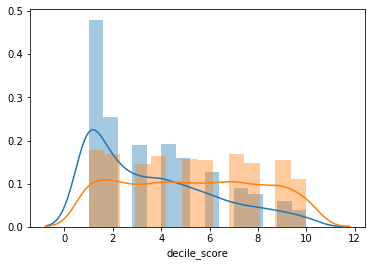

In [6]:
# Code to create a histogram for the risk scores for white defendants
white_data = select_data[select_data["race"] == "Caucasian"]
sns.distplot(white_data["decile_score"], hist=True, rug=False)

# Code to create a histogram for the risk scores for Black defendants
black_data = select_data[select_data["race"] == "African-American"]
sns.distplot(black_data["decile_score"], hist=True, rug=False) # This plot will layer over the previous plot

### Question 3a (i)
Is one racial group more likely to get a high risk score opposed to the other? 

*Student Written Answer Here*

### Question 3a (ii)
 Why is your answer from part (i) being relfected in this histogram (why is there disparity), and how can you connect this to your knowledge of the history of policing and institutionalized racism? 

*Student Written Answer Here*

## Question 4. FPR and FNR: Does COMPAS overpredict or underpredict across groups?

Recall that models use algorithms to predict a target feature (in this case the likelihood of recidivism). We can evaluate how well a model predicts these features by using ***goodness metrics***. Goodness metrics typically summarize discrepancies between actual values and predicted values. Metrics like these are quite important in data science and typically are used by data scientists to determine how accurate and effective an algorithm is at predicting its predetermined goal.  

In order to answer this question and understand the ways in which bias is present in the risk scores, ProPublica used the **False Positive Rate (FPR) and False Negative Rate (FNR)** as their metrics to understand and quantify fairness. In terms of COMPAS, the FPR tells us the percentage of defendants that do not reoffend even though they were predicted to reoffend by the algorithm (*the defendants that did not reoffend and received a “high” score*). On the other hand, the FNR tells us the percentage of defendants that do reoffend even though they were predicted to not reoffend by the algorithm (*the defendants that did reoffend and received a “low” score*). 

Below we have calculated the False Positive Rates and False Negative rates based on the data from the risk scores. 

In [7]:
def fpr(race_feature, data):
    # Function returns the False Positive Rate of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    did_not_recidivate = subgroup[subgroup["two_year_recid"] == 0]

    fp = did_not_recidivate[did_not_recidivate["decile_score"] > 4].shape[0]
    tn = did_not_recidivate[did_not_recidivate["decile_score"] <= 4].shape[0]
    return fp / (fp + tn)


def fnr(race_feature, data):
    # Function returns the False Negative Rate of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    recidivated = subgroup[subgroup["two_year_recid"] == 1]
    
    fn = recidivated[recidivated["decile_score"] <= 4].shape[0]
    tp = recidivated[recidivated["decile_score"] > 4].shape[0]
    return fn / (fn + tp)


In [8]:
# Apply the metrics to the dataset
print("FPR for Black defendants:", round(fpr("African-American", select_data), 5) * 100, "%")
print("FPR for white defendants:", round(fpr("Caucasian", select_data), 5) * 100, "%")
print("FNR for Black defendants:", round(fnr("African-American", select_data), 4) * 100, "%")
print("FNR for white defendants:", round(fnr("Caucasian", select_data), 5) * 100, "%")

FPR for Black defendants: 42.338 %
FPR for white defendants: 22.014 %
FNR for Black defendants: 28.48 %
FNR for white defendants: 49.635 %


**FIX: These questions below can be redone I think - if we explain what overprediction and underprediction are in terms of fpr and fnr, and we do the calculations for them.**

### Question 4b
What can you conclude from these metrics about the overprediction of risk scores for Black and white defendants? By how much is the tool overpredicting?

In [9]:
# Calculation of ratio for FPR
fpr("African-American", select_data) / fpr("Caucasian", select_data)

1.9232342111919953

*Student Written Answer Here*

### Question 4c
What can you conclude from these metrics about the underprediction of risk scores for Black and white defendants? By how much is the tool underpredicting?

In [10]:
# Calculation of ratio for FNR
fnr("Caucasian", select_data) / fnr("African-American", select_data)

1.7429977932439313

*Student Written Answer Here*

##  Question 5.

### Question 5a (i)
Utilizing your answers from 1b and 2b, what problems does ProPublica highlight in the COMPAS algorithm? 

*Student Written Answer Here*

### Question 5a (ii)
How might we understand and interpret ProPublica’s definition of fairness, after understanding the metrics they used?

*Student Written Answer Here*

### Question 5b 
Why did ProPublica choose to investigate bias between races rather than a different sensitive feature? (Hint: think about how ProPublica’s conclusions reflect the racial disparities in our current criminal justice system.)

*Student Written Answer Here*

### Question 5c
What is ProPublica’s agenda as an investigative journalism organization? How do we see this in their analysis and conclusions?

*Student Written Answer Here*

Now that we’ve analyzed ProPublica’s perspective, let’s move on to Northpointe’s.


# Part 3. Northpointe's Perspective <a id="part-three"></a>

### Who is Northpointe? (acquired by equivant)

Northpointe (now under the company equivant) is a for-profit computer software company that aims to advance justice by informing and instilling confidence in decision makers at every stage of the criminal justice system. equivant has developed a variety of technologies since COMPAS, specializing in court case management, attorney case management, inmate classification, and risk/needs assessment strategies. 

In the wake of criticism from ProPublica and other researchers alike, Northpointe produced a detailed response to ProPublica’s allegations claiming that these critiques of their tool utilized the wrong type of classification statistics in their analysis and portrayed the tool incorrectly. The company provided their own analysis of the COMPAS algorithm by using different statistical methods and responding individually to ProPublica’s claims of racial bias against Black defendants. Upon examining their tool’s fairness through accuracy equity (a metric that was left out of ProPublica’s analysis) and through the fact that the model was not trained with a race feature, Northpointe concluded that their algorithm treats all citizens and specified groups equally, and therefore does not exhibit signs of bias or inequality for specified groups. Now, let’s take a look at how Northpointe proved their argument.


## Question 6. Sensitive Features: How can a model be racially biased without a race feature?

Northpointe made it very clear that they did not utilize any race feature (a column that informs the algorithm of the race of each defendant) in their dataset when they were training their algorithm. Northpointe decided that as a result of neglecting this race feature, the COMPAS tool would not take race into account when making decisions for defendants and therefore cannot be biased against certain races. 

### Question 6a

Think back to our discussion about sensitive features and proxies. Can you think of any way race is still embedded in the algorithm, even though it does not use a race feature to make decisions?

*Student Written Answer Here*

### Question 6b

Why might neglecting to consider race in the context of the US criminal justice system be harmful or problematic? 

*Student Written Answer Here*

### Question 6c

Can data scientists’ algorithms be absolved of racial bias if they decide to not take race into account within their models? Explain why or why not. 

*Student Written Answer Here*

## Question 7: Accuracy Equity: Is each group being discriminated against equally?

Instead of the model errors FNR and FPR (the metrics you calculated in the previous ProPublica section), Northpointe found it more appropriate to use the complement of FNR, known as the TPR (or what is often referred to as Sensitivity), paired with the FPR in a visualization called the **ROC Curve**. Once again, the TPR is a new way to measure the “goodness” of a model, similar to FNR and FPR.
In data science, we can use a visualization called the **Receiver Operating Characteristic (ROC) curve** to interpret ***how much a model is capable of distinguishing between classes***. We do this by plotting the curve and deriving the **Area Under the Curve (AUC)**. The higher the AUC, the better the model is at predicting our target variable. Northpointe utilized this method by plotting metrics we have already calculated: the FPR on the x-axis and TPR on the y-axis, and then calculating and comparing the AUC for the subgroup of data with white defendants and the subgroup of data with Black defendants.

Below is the code to create this visualization. You do not need to understand the code itself, but feel free to go through it yourself! 

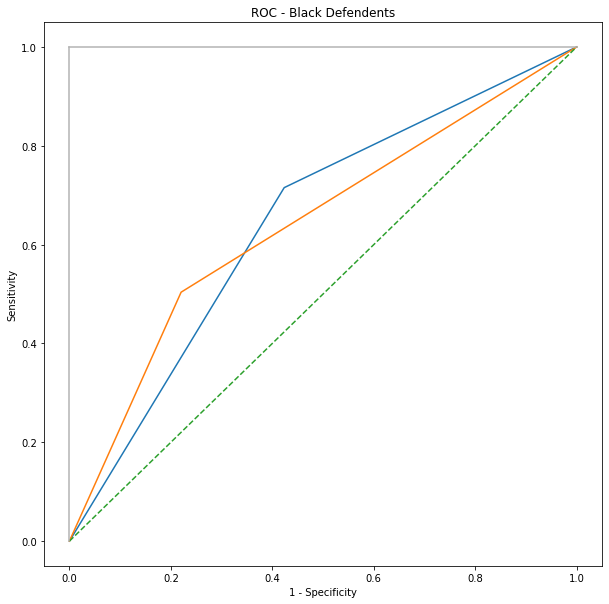

In [11]:
# Calculate FPR and FNR from metrics package - Black defendants
black_def = select_data[select_data["race"] == "African-American"]
# True values (if the defendants reoffended)
y1 = black_def['two_year_recid']
# Predicted values from COMPAS tool (risk scores)
pred1 = black_def["decile_score"].replace([1, 2, 3, 4], 0).replace([5, 6, 7, 8, 9, 10], 1)
fpr_black, tpr_black, threshold = roc_curve(y1, pred1)

# Calculate FPR and FNR from metrics package - White defendants
white_def = select_data[select_data["race"] == "Caucasian"]
# True values (if the defendants reoffended)
y2 = white_def['two_year_recid']
# Predicted values from COMPAS tool (risk scores)
pred2 = white_def["decile_score"].replace([1, 2, 3, 4], 0).replace([5, 6, 7, 8, 9, 10], 1)
fpr_white, tpr_white, threshold = roc_curve(y2, pred2)

# Set up the plot for the ROC curve
plt.subplots(1, figsize=(10,10))
plt.title('ROC - Black Defendents')
plt.plot(fpr_black, tpr_black)
plt.plot(fpr_white, tpr_white)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
plt.show()


In [12]:
# Calculate and print the AUC
print("AUC for Black defendants:", roc_auc_score(y1, pred1))
print("AUC for white defendants:", roc_auc_score(y2, pred2))

AUC for Black defendants: 0.6459250089670798
AUC for white defendants: 0.641754559907007


### Question 7a (i). 

What do you notice from the ROC curve and the AUC calculation? Please list at least 2 observations.

*Student Written Answer Here*

### Question 7a (ii). 
What could Northpointe take away from this visualization to prove their point? (Hint: Is each racial group being discriminated against equally? Can you distinguish between racial groups or are they more or less the same?) 

Recall: the AUC helps us determine by how much a model is capable of distinguishing between classes.

*Student Written ANswer Here*

## Question 8.

### Question 8a

How might we understand and interpret Northpointe’s definition of fairness, after learning and utilizing the metrics they used?

*Student Written Answer Here*

### Question 8b 

Why might Northpointe be more interested in these specific metrics of fairness and accuracy (both the AUC and the deliberate neglect of the race feature), given trends of colorblindness in the US?

*Student Written Answer Here*

### Question 8c

Is there anything that Northpointe is forgetting to consider in their analysis? Is there anything ProPublica is forgetting to consider in their analysis? Please explain.

So far, we’ve investigated ProPublica’s and Northpointe’s definitions of fairness. In the world of machine learning there are many more, so in the next section we will take a look at a third definition.

# Part 4. Another Definition of Fairness <a id="part-four"></a>

In this section, you will go through yet another metric used to evaluate fairness in machine learning: disparate impact. Disparate impact is a legal doctrine that determines if there is unintended discrimination towards a protected class. Instead of evaluating the fairness of the COMPAS tool after it has been trained, we will instead notice and remove bias from the dataset before the model is created to demonstrate another technique for creating a fair algorithm. In order to do so, we need to quantify the disparate impact in the dataset and utilize aif360 (a special Python package with fairness tools for machine learning) to remove the bias completely. 


## Question 9. Disparate Impact: Quantification and Removal

First, let’s visualize the disparity that we would like to remove from the dataset by utilizing the same histogram we created in question 3.  

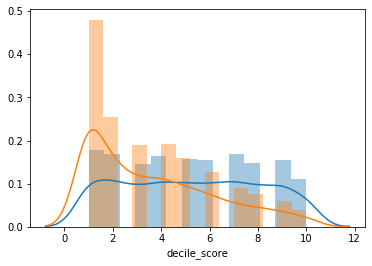

In [14]:
unpriv = select_data[select_data["race"] == "Caucasian"]
priv = select_data[select_data["race"] == "African-American"]
sns.distplot(priv["decile_score"], hist=True, rug=False)
sns.distplot(unpriv["decile_score"], hist=True, rug=False)

As you observed in question 3, this histogram illuminates the disparity in scores for Black and white defendants. 

Now, let’s quantify the disparate impact we are seeing in the plot. In order to do that we need to distinguish between a **privileged group** and an **unprivileged group**. In technical terms, *the privileged group receives disproportionately higher scores from a trained model than the unprivileged group*, so therefore the Black defendants will be considered "privileged" and the white defendants will be considered "unprivileged" in this case. In machine learning, we can understand disparate impact as the proportion of individuals that get positive outcomes (positive outcomes, meaning if they received a high score) for the two groups described above.

The function below calculates disparate impact exactly as described above. We then apply this function to our own dataset to get the following quantification.

In [27]:
def proportion(data, group):
    # Returns the proportion of individuals in data from the group who get a high risk score
    race_group = data[data["race"] == group]
    positive_outcomes = race_group[race_group["decile_score"] > 4]
    return len(positive_outcomes) / len(race_group)

In [22]:
prob_priv = proportion(select_data, "African-American")
prob_unpriv = proportion(select_data, "Caucasian")
prob_unpriv / prob_priv

0.5745131730114521

In industry, if the proportion of unprivileged individuals receiving positive outcomes to privileged individuals receiving positive outcomes is less than 80%, there is a disparate impact violation.

### Question 9a
Is there a disparate impact violation in our dataset? What is one reason that could explain this outcome? 

*Student Written Answer Here*

In order to stop a trained model from replicating these biases in its output, we can now use the Python package aif360’s Disparate Impact Remover (a tool that was created and designed specifically to eliminate disparate impact in a dataset) to remove the bias we just calculated. The code below does this by creating a specific type of dataset ([documentation for BinaryLabelDataset](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset)) from our original dataset and creating a DisparateImpactRemover type object ([documentation for DisparateImpactRemover](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html)) with the new dataset that eliminates the disparate impact and outputs a transformed dataset. You do not need to understand this code, but feel free to go through it yourself!



In [23]:
# Create new DataFrame with just the necessary columns - Only numeric values for race, decile score, and two year recid
race_data = select_data[(select_data["race"] == "Caucasian") | (select_data["race"] == "African-American")]
race_col = pd.get_dummies(race_data, "race")["race_Caucasian"]
noise = np.random.normal(0, 0.1, race_data.shape[0])
decile_col = race_data["decile_score"] + noise
recid_col = race_data["two_year_recid"]
new_df = pd.DataFrame({"race": race_col, "decile_score": decile_col, "two_year_recid": recid_col})

# Create BinaryLabelDataset
BLD = BinaryLabelDataset(favorable_label=1, # Positive Outcome
                         unfavorable_label=0, # Negative Outcome
                         df=new_df,
                         label_names=["two_year_recid"],
                         protected_attribute_names=["race"],
                         unprivileged_protected_attributes=[1])

In [24]:
remover = DisparateImpactRemover(repair_level=1.0, sensitive_attribute="race")
transformed_data = remover.fit_transform(BLD)

### Question 9b
Using the code from our original histogram, create your own histogram to plot the scores from the modified dataset (transformed_df, created below).

In [ ]:
# Transform output from DIRemover into usable DataFrame
# Use this dataset instead of select_data
transformed_df = pd.DataFrame(np.hstack([transformed_data.features, transformed_data.labels]),
                              columns=["race","decile_score","two_year_recid"])

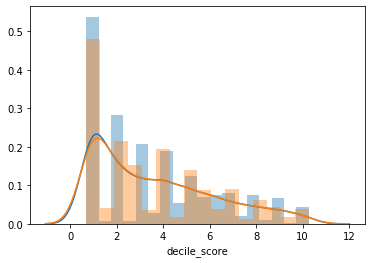

In [25]:
unpriv_t = transformed_df[transformed_df["race"] == 1]
priv_t = transformed_df[transformed_df["race"] == 0]
sns.distplot(priv_t["decile_score"], hist=True, rug=False)
sns.distplot(unpriv_t["decile_score"], hist=True, rug=False)

### Question 9c 
Using code from above, once again calculate the disparate impact, but this time on the modified dataset (transformed_df).

In [26]:
# Calculate disparate impact
# Use transformed_df instead of select_data
prob_priv_t = proportion(transformed_df, 0)
prob_unpriv_t = proportion(transformed_df, 1)
prob_unpriv_t / prob_priv_t

0.9998823920595494

### Question 9d

What has changed from our original histogram? Please explain why this change has happened. 

*Student Written Answer Here*

### Question 9e

How might we understand this definition of fairness, after learning and utilizing these metrics? 

*Student Written Answer Here*

## Question 10

Just now, we used your technical data science skills to remove bias from the data set. However, it’s important to remember that not everyone has those skills! Beyond data science expertise, there are many types of knowledge and experiences that are necessary to take into account when analyzing an algorithm like COMPAS. As such, you will think through issues of expertise and fairness in the next set of questions.

### Question 10a

Who is being impacted by this algorithm when it is utilized in court systems?

*Student Written Answer Here*

### Question 10b

What expertise and lived experiences are necessary to understand and critically think about the issues produced by COMPAS?

*Student Written Answer Here*

### Question 10c

Why is this third definition of fairness still inadequate? (Hint: look at the question and answer from Q8c).

*Student Written Answer Here*

### Question 10d

How does this definition of fairness differ from ProPublica’s and Northpointe’s? 

*Student Written Answer Here*